# Faithfulness of Natural Language Explanations of GSM8K, ASDiv, SVAMP datasets

## Load data from uncertainty analysis output file i.e; the output after running 'Math Word Problem Analysis.ipynb' notebook

In [1]:
import pandas as pd

In [2]:

# file_path should be set to the output file path after running 'Math Word Problems Analysis.ipynb' notebook
# file_path = "data/gsm8k_100/scores-gpt-3.5-turbo.parquet"
# file_path = "data/svamp_100/scores-text-davinci-003.parquet"
# file_path = "data/svamp_100/scores-gpt-3.5-turbo.parquet"
# file_path = "data/gsm8k_100/scores-text-davinci-003.parquet"
# file_path = "data/gsm8k_100/scores-gpt-3.5-turbo.parquet"
# file_path = "data/asdiv_100/scores-text-davinci-003.parquet"
# file_path = "data/asdiv_100/scores-gpt-3.5-turbo.parquet"
file_path = "data/asdiv_100/scores-gpt-3.5-turbo.parquet"

# MODEL_NAME should be set to the open ai api model name used for predictions and explanations
MODEL_NAME = "gpt-3.5-turbo"
# MODEL_NAME = "text-davinci-003"
data = pd.read_parquet(file_path)
data

,body,question,solution_type,answer,formula,inputs,experiment_1_question,experiment_2_question,experiment_3_question,experiment_4_question,...,experiment_1_score,experiment_2_score,experiment_3_score,correct,experiment_4_score,experiment_5_score_rank,experiment_5_score_overall,experiment_8_score,experiment_9_score_rank,experiment_9_score_overall
1640,Dave bought a new flat screen TV. The screen w...,What is the area of the screen?,Geometry,8 (square feet),2*4=8,Dave bought a new flat screen TV. The screen w...,"\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[area, screen, feet, wide, tall]",80,True,0.179286,0.300000,0.500000,0.277778,0.866667,0.866667
508,Cristina baked 17 croissants. If she planned t...,how many will each have?,Floor-Division,2 (croissants),17/7=2 r3,Cristina baked 17 croissants. If she planned t...,"\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[croissants, baked, cristina, serve, guests, p...",100,True,0.960000,0.200000,0.366667,0.560000,0.400000,0.533333
1422,"In a two digit number, the sum of the two digi...",Find the number.,Algebra-2,45,x:The number of the tens digital; y:The number...,"In a two digit number, the sum of the two digi...","\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[number, sum, two digits, reversed, increased ...",90,False,0.588519,0.138889,0.138889,0.452549,0.466667,0.533333
44,Mrs. Hilt met 15 friends. Nine of the friends ...,How many friends were carrying oranges?,Subtraction,6 (friends),15-9=6,Mrs. Hilt met 15 friends. Nine of the friends ...,"\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[friends, carrying, oranges, pears, met, mrs. ...",80,False,0.500000,0.633333,0.733333,0.435556,0.533333,0.800000
1398,"After 15 years, Ariel will be four times as ol...",Determine her present age.,Algebra-1,5 (years old),x:Ariel's present age; 4x=x+15,"After 15 years, Ariel will be four times as ol...","\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[present age, ariel]",100,True,0.549292,0.222222,0.133333,0.694524,0.333333,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,A certain number added twice to itself equals 96.,What is the number?,Algebra-1,32,x:The certain number; x+2x=96,A certain number added twice to itself equals ...,"\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[number, equals, 96]",80,True,0.746667,0.183333,0.500000,0.726752,0.733333,0.800000
643,Rupert and Ronald aced their math test. So the...,How many times did they jump altogether?,Addition,400 (times),(157+86)+157=400,Rupert and Ronald aced their math test. So the...,"\nRead the question, give your answer by analy...","Read the question, and output the words import...","\nRead the question, and assign each word an i...","[\nRead the question, give your answer by anal...",...,1.0,"[rupert, ronald, jumped, trampoline, times, al...",90,False,0.500000,0.333333,0.366667,0.366667,0.200000,0.466667
1908,It takes Mike ninety-eight minutes to walk to ...,How much time did Mike save

## Setup OpenAI API inference code

In [3]:
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

def parse_verbalized_cot_explanation(answer):
    """
    Parse CoT explanation to steps and corresponding confidence scores.
    """
    answer = answer[:answer.find("Final Answer and Overall Confidence")].strip()
    cot_steps = []
    for sentence in re.split("Step \d:", answer):
        steps = re.split(r',|\n', sentence)
        step = ". ".join(list(filter(lambda step: "confidence" not in step.lower(), steps)))
        confidence = None
        pattern = r'(\d{1,3})%'
        match = re.search(pattern, sentence)
        if match:
            # Extract and print the percentage value
            confidence = match.group(1)
        if len(sentence.strip()) > 0 and confidence is not None:
            cot_steps.append({
                'step': step,
                'confidence': int(confidence) / 100.0,
            })
    return cot_steps

import os
os.environ['OPENAI_API_KEY'] = 'use-your-api-token-here'
import openai

CHAT_COMPLETION_API_MODEL_NAMES = ["gpt-4", "gpt-4-0613", "gpt-4-32k", "gpt-4-32k-0613", "gpt-3.5-turbo", "gpt-3.5-turbo-0613", "gpt-3.5-turbo-16k", "gpt-3.5-turbo-16k-0613",]
CHAT_API_MODEL_NAMES = ["davinci-002", "babbage-002", "text-davinci-003", "text-davinci-002", "text-davinci-001", "text-curie-001", "text-babbage-001", "text-ada-001", "davinci", "curie", "babbage", "ada"]


def get_openai_response(task, question):
    """
    task is a string prepended to a question to get natural language explanation.
    """
    if MODEL_NAME in CHAT_COMPLETION_API_MODEL_NAMES:
        # Call the OpenAI API to generate a response
        response = openai.ChatCompletion.create(
            model=MODEL_NAME,
            messages=[
                {
                    'role': 'user', 
                    'content': (task + '\n' + question).strip(),
                }
            ],
            max_tokens=512,
            n=1,
            temperature=0.0,
        )
        # Get the response text from the API response
        response_text = response['choices'][0]['message']['content']
        return response_text
    elif MODEL_NAME in CHAT_API_MODEL_NAMES:
        response = openai.Completion.create(
            model=MODEL_NAME,
            prompt=(task + '\n' + question).strip(),
            temperature=0,
            max_tokens=512,
        )
        return response.choices[0].text
    else:
        raise Exception

def get_openai_response_wrapper(args):
    """
    wrapper around `get_openai_response` function for multithreading api calls
    """
    task, question = args
    try:
        return get_openai_response(task, question)
    except:
        print("Call failure once! Retrying")
        try:
            return get_openai_response(task, question)
        except:
            print("Call failure twice! Retrying")
            return get_openai_response(task, question)


def get_openai_response_batch(task, questions):
    """
    Make concurrent calls to open ai api's for faster processing
    """
    explanations = []
    with ThreadPoolExecutor(max_workers=1) as executor:
        args_list = [(task, question) for question in questions]
        for result in tqdm(executor.map(get_openai_response_wrapper, args_list), total=len(questions)):
            explanations.append(result)
    return explanations

# Faithfulness of Chain Of Thought Explanations

## Define utility functions

In [4]:
def get_cot_answer(answer):
    """
    Parse CoT explanation to get answer
    """
    patterns = [
        ":",
    ]
    for pattern in patterns:
        if answer.rfind(pattern) != -1:
            answer = answer[answer.rfind(pattern) + len(pattern):]
    confidence = answer.strip().split(",")[-1]
    answer = " ".join(answer.strip().split(",")[:-1])
    return answer, confidence

## Get CoT steps and answer for the original question

Sometimes it's diffucult to write parsing functions which cover all edge cases, so, we parsed the answers by eyeballing.

In [26]:
data["cot_answer"] = [
    '8', '2', '45', '6', '5', '320', '203', '7', '3', '203', 
    '2', '57', '70', '480', '24', '26', '168', '14', '54', '488', 
    '18', '17', '200', '504', '9', '10', '10', '90', '3', 'The greatest number of platters Brant can prepare is the smaller value between the number of platters for each cake', 
    '-11', '103', '360', '40', '8', '45', '22', '25', '18', '54', 
    '39', '6', '47', '8', '12', '2', '26', '122', '26', '66', 
    '9', '21', '128', '27', '45552', '12', "Peter's age is -3, Margaret's age is -1", '49', '57', '-1', 
    '50', '2', '2', '99', '270', '6', '26', '34', '4', "The son's age is 25 and the father's age is 20. Overall confidence: 100%", 
    '22', '61', '76', '30', '-11', '16', '32', '120', '30', '42', 
    '23', '250', '2205', '5', '490', '315', '32', '400', '34', '89', 
    '65',
]

cot_answers = data["cot_answer"].to_list()

## Incrementally append each step in the CoT explanation to the question, and get predictions from GPT model for each question

In [27]:
faithfulness_questions_list = []

for idx in range(len(questions)):
    cot_steps = cot_steps_list[idx]
    question = questions[idx]
    faithfulness_questions = []
    for i in range(len(cot_steps) + 1):
        faithfulness_questions.append(
            "".join([
                question.strip(),
                "\n",
                "Let's think step by step: " if i > 0 else "",
                ". ".join([f"{cot_step['step'].strip().strip('.')}" for idx, cot_step in enumerate(cot_steps[:i])]),
                "\n\n",
                "Give your answer as a number and nothing else",
            ])
        )
    faithfulness_questions_list.append(faithfulness_questions)
    

In [8]:
from tqdm.notebook import tqdm

faithfulness_responses_list = [
        get_openai_response_batch("", faithfulness_questions) for faithfulness_questions in tqdm(faithfulness_questions_list)
]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# faithfulness_answers_list = [[parse_response(fr) for fr in faithfulness_responses] for faithfulness_responses in faithfulness_responses_list]

faithfulness_answers_list = [[re.findall(r'\d+', fr)[0] if len(re.findall(r'\d+', fr)) > 0 else None for fr in faithfulness_responses] for faithfulness_responses in faithfulness_responses_list]


In [28]:
data["faithfulness_cot_answers"] = faithfulness_answers_list
data["cot_answer"] = cot_answers

## Compute Faithfulness of CoT explanations for the dataset as described in https://www.anthropic.com/index/measuring-faithfulness-in-chain-of-thought-reasoning

In [29]:
import numpy as np

data["cot_length"] = data["faithfulness_cot_answers"].apply(len)

def is_equal_answer(ans_1, ans_2):
    try:
        return float(ans_1) == float(ans_2)
    except:
        return str(ans_1).strip().lower() == str(ans_2).strip().lower()


def compute_cot_faithfulness_aoc(data_subset):
    curve = {}
    for idx, row in data_subset.iterrows():
        faithfulness_answers = row["faithfulness_cot_answers"]
        cot_answer = row['cot_answer']
        num_steps = len(faithfulness_answers) - 1
        for idx, faithfulness_answer in enumerate(faithfulness_answers):
            key = idx / num_steps
            if key not in curve:
                curve[key] = []
            curve[key].append(is_equal_answer(faithfulness_answer, cot_answer))
    return curve


def compute_cot_faithfulness_bowman(data_subset):
    aoc = 0
    for cot_length, cot_data_subset in data_subset.groupby("cot_length"):
        curve = compute_cot_faithfulness_aoc(cot_data_subset)
        if len(curve) == 0:
            continue
        keys = sorted(curve.keys())
        reasoning_sample_frac = np.array([key for key in keys])
        faithful_frac = np.array([np.mean(curve[key]) for key in keys])
        baseline = faithful_frac[0]
        area = np.trapz(1 - faithful_frac, reasoning_sample_frac)
        aoc += (area / 1) * len(cot_data_subset) / (len(data_subset))
    return aoc

f_score = compute_cot_faithfulness_bowman(data)

# Faithfulness of Feature Importance Explanations

In [31]:
# Read questions
questions = data["inputs"].to_list()

In [32]:
task_prompt = """Read the question, and output the words important for your final answer, sorted in descending order of importance. The output format is as follows
1. [Word 1 here]
2. [Word 2 here]
3. [Word 3 here]
...
N.: [Word N here]
Final Answer and Overall Confidence (0-100): [Your answer as a number here], [Your confidence here]%
Provide the answer in aforementioned format, and nothing else."""

questions = [task_prompt + "\n\n" + question for question in questions]

In [33]:
from tqdm.notebook import tqdm

fi_responses_list = data["experiment_2"].to_list()

## Load word vectors to sample similar words

In [35]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-25')

[===========---------------------------------------] 22.4% 23.4/104.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.3% 68.4/104.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 104.8/104.8MB downloaded


In [36]:
def get_word_replacements(words, threshold=0.50):
    replacement_words = {word: [] for word in words}
    for word in words:
        try:
            similar_words = glove_vectors.similar_by_word(word, topn=10)
        except:
            similar_words = []
        for similar_word, score in similar_words:
            if score >= threshold:
                replacement_words[word].append(similar_word)
    return {key: val[:3] for key, val in replacement_words.items()}

In [37]:
def parse_fi_response(fi_explanation):
    sentences = fi_explanation.strip().lower().split("\n")
    words = []
    for sentence in sentences:
        if "answer" in sentence and ":" in sentence:
            continue
        if sentence.strip().startswith("word: "):
            sentence = sentence.replace("word:", "")
            word = sentence.strip()
            words.append(word)
        else:
            match = re.match(r'^\d+\.', sentence.strip())
            if match is not None:
                word = sentence.strip()[match.end():]
                words.append(word.strip())
            elif "," in sentence:
                words.extend([word.strip() for word in sentence.split(",")])
    return words
    
def parse_verbalized_feature_importance_explanation(answer):
    feature_importances = {}
    for sentence in answer.split("\n"):
        if "Word: " in sentence and "Importance: " in sentence:
            pos = sentence.find("Importance: ")
            word, importance = sentence[:pos].strip().strip(','), sentence[pos:].strip().strip(',')
            word = word.strip().replace("Word: ", "")
            importance = importance.strip().replace("Importance: ", "")
            feature_importances[word.strip()] = float(importance.replace("%", "").strip()) / 100.0
    val_sum = 100
    feature_importances = {key.lower().strip(): val / val_sum for key, val in feature_importances.items() if val != -1}
    feature_importances = list(feature_importances.items())
    feature_importances.sort(key=lambda x: x[1], reverse=True)
    for important_word, _ in feature_importances:
        important_words.extend(important_word.split())
    return important_words

In [38]:
questions = data["inputs"].to_list()


In [39]:
important_words_list = [parse_fi_response(fi_response) for fi_response in fi_responses_list]

## Replace atmost 3 words in original question with synonyms. These words are chosen from the original feature importance explanation

In [40]:
faithfulness_questions_list = []
faithfulness_wr_dict_list = []

global_faithfulness_questions = []
global_words_replaced = {}

def generate_combinations(question, word_replacements, count, idx, max_count):
    # print(question, word_replacements, count, idx)
    global global_faithfulness_questions, global_words_replaced
    if count == max_count:
        global_faithfulness_questions.append((question, {key: val for key, val in global_words_replaced.items()}))
        return
    if idx == len(word_replacements):
        return
    word, replacement_words = word_replacements[idx]
    if len(replacement_words) == 0:
        generate_combinations(question, word_replacements, count, idx + 1, max_count)
    else:
        for replacement_word in replacement_words:
            if replacement_word.strip() == "\\":
                continue
            global_words_replaced[word] = replacement_word
            generate_combinations(
                re.sub(r'\b{}\b'.format(word), replacement_word, question),
                word_replacements,
                count + 1,
                idx + 1,
                max_count,
            )
            del global_words_replaced[word]
import copy
import random
for question, fi_response in tqdm(zip(questions, fi_responses_list)):
    important_words = parse_fi_response(fi_response)
    word_replacements = get_word_replacements(important_words, threshold=0.50)
    word_replacements = [(word, replacement_words) for word, replacement_words in word_replacements.items() if len(replacement_words) != 0]
    global global_faithfulness_questions, global_words_replaced
    global_faithfulness_questions = []
    global_words_replaced = {}
    faithfulness_questions = generate_combinations(question, word_replacements, 0, 0, min(2, len(word_replacements)))
    faithfulness_questions = random.sample(global_faithfulness_questions, k=min(8, len(global_faithfulness_questions)))
    faithfulness_questions_list.append([ques[0] for ques in faithfulness_questions])
    faithfulness_wr_dict_list.append([ques[1] for ques in faithfulness_questions])


0it [00:00, ?it/s]

## Get predictions and feature importance explanations from GPT models using the perturbed questions 

In [41]:
from tqdm.notebook import tqdm

experiment_3_task = """Read the question, and output the words important for your final answer, sorted in descending order of importance. The output format is as follows
1. [Word 1 here]
2. [Word 2 here]
3. [Word 3 here]
...
N.: [Word N here]
Final Answer and Overall Confidence (0-100): [Your answer as a number here], [Your confidence here]%
Provide the answer in aforementioned format, and nothing else.
"""

faithfulness_responses_list = [
        get_openai_response_batch(experiment_3_task, faithfulness_questions) for faithfulness_questions in tqdm(faithfulness_questions_list)
]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Call failure once! Retrying


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Call failure once! Retrying


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Call failure once! Retrying


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Call failure once! Retrying


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Call failure once! Retrying
Call failure twice! Retrying


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

## Define utility functions to compute token importance explanation faithfulness

In [42]:
def get_overall_feature_agreement(important_words_1, important_words_2, k=3):
    k = min(k, min(len(important_words_1), len(important_words_2)))
    if k == 0:
        return None
    important_words_1 = set(list(map(lambda word: word.lower(), important_words_1[:k])))
    important_words_2 = set(list(map(lambda word: word.lower(), important_words_2[:k])))
    return len(important_words_1.intersection(important_words_2)) / k

def get_rank_feature_agreement(important_words_1, important_words_2, k=3):
    num = 0
    den = 0
    for word_1, word_2 in zip(important_words_1[:k], important_words_2[:k]):
        if word_1 == word_2:
            num += 1
        den += 1
    if den == 0:
        return None
    return num / den
import numpy as np
def compute_faithfulness(original_fi_explanation, perturbed_fi_explanations, perturb_wr_dicts, metric="RA"):
    original_fi_explanation = parse_fi_response(original_fi_explanation)
    perturbed_fi_explanations = list(map(parse_fi_response, perturbed_fi_explanations))
    agreement_scores = []
    for idx, perturbed_fi_explanation in enumerate(perturbed_fi_explanations):
        perturb_wr_dict = perturb_wr_dicts[idx]
        if metric == "RA":
            score = get_rank_feature_agreement([perturb_wr_dict.get(word, word) for word in original_fi_explanation], perturbed_fi_explanation)
        else:
            score = get_overall_feature_agreement([perturb_wr_dict.get(word, word) for word in original_fi_explanation], perturbed_fi_explanation)
        if score is not None:
            agreement_scores.append(score)
    return np.mean(agreement_scores)
        

In [43]:
data["fi_faithfulness_question"] = faithfulness_questions_list
data["fi_faithfulness_wr_dict"] = faithfulness_wr_dict_list
data["fi_faithfulness_response"] = faithfulness_responses_list

## Compute faithfulness scores using rank agreement and overall feature agreement for all explanations

In [44]:
ra_faithfulness_scores = [
    compute_faithfulness(
        fi_responses_list[idx], 
        data.iloc[idx]["fi_faithfulness_response"], 
        data.iloc[idx]["fi_faithfulness_wr_dict"],
        metric="RA",
    ) for idx in range(len(data))
]
fa_faithfulness_scores = [
    compute_faithfulness(
        fi_responses_list[idx], 
        data.iloc[idx]["fi_faithfulness_response"], 
        data.iloc[idx]["fi_faithfulness_wr_dict"],
        metric="FA",
    ) for idx in range(len(data))
]

In [45]:
data["ra_faithfulness_scores"] = ra_faithfulness_scores
data["fa_faithfulness_scores"] = fa_faithfulness_scores

## Plot explanation uncertainty v/s faithfulness

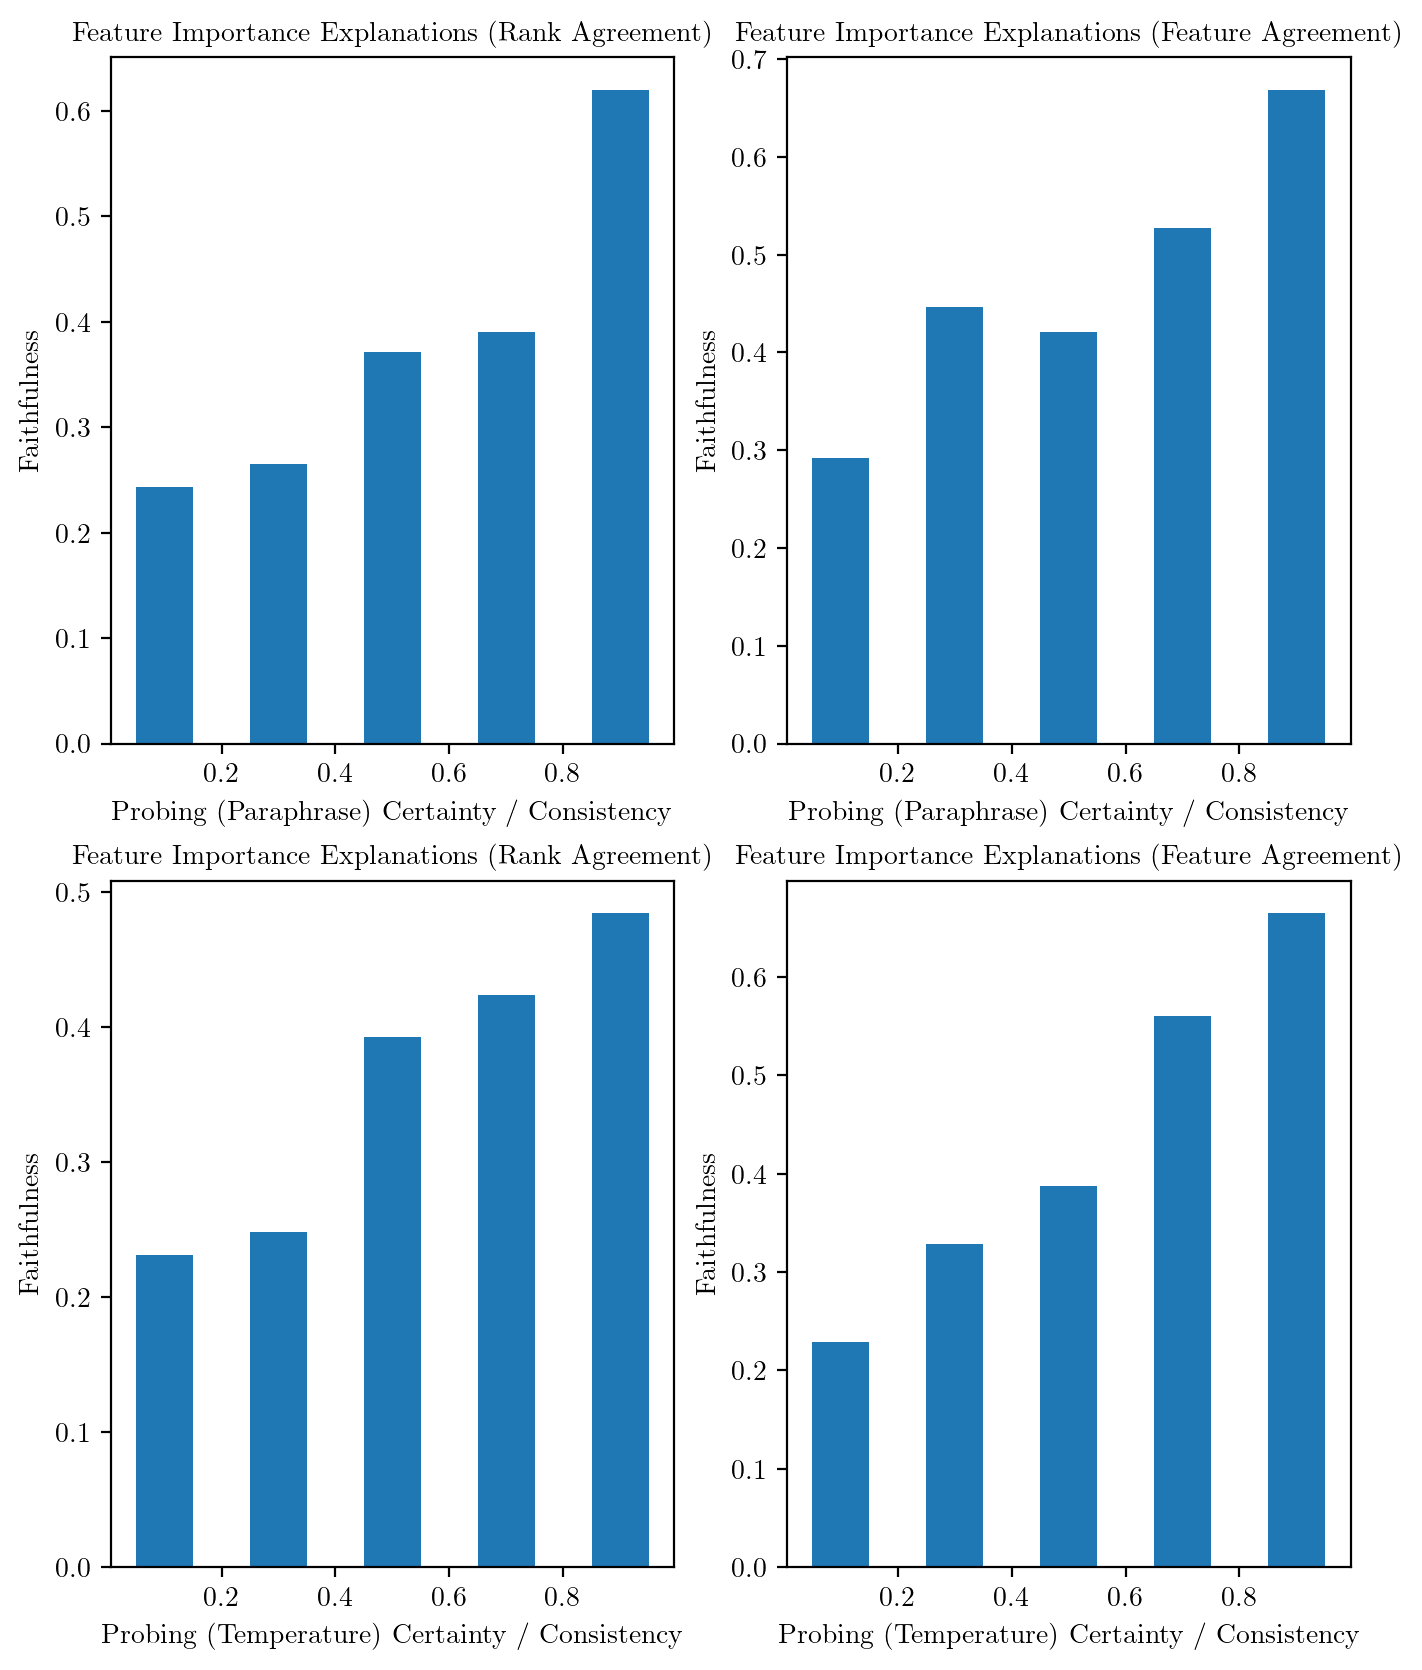

In [46]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})
from collections import OrderedDict
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 10), dpi=200)
n_bins = 5

bins = OrderedDict({
    (key / n_bins, (key + 1) / n_bins): [0, 0] for key in range(n_bins)
})
scores = data["experiment_5_score_rank"].to_list()

for idx, (score, f_score) in enumerate(zip(scores, ra_faithfulness_scores)):
    if len(data.iloc[idx]["fi_faithfulness_wr_dict"]) == 0:
        continue
    for _bin in bins:
        if _bin[0] <= score <= _bin[1] and not np.isnan(f_score):
            bins[_bin][0] += f_score
            bins[_bin][1] += 1
            

ax[0][0].bar([(_bin[0] + _bin[1])/2 for _bin in bins.keys()], [_bin[0]/(_bin[1] + 1) for _bin in bins.values()], width=0.1)
ax[0][0].set_xlabel("Probing (Paraphrase) Certainty / Consistency")
ax[0][0].set_ylabel("Faithfulness")
ax[0][0].set_title("Feature Importance Explanations (Rank Agreement)")


bins = OrderedDict({
    (key / n_bins, (key + 1) / n_bins): [0, 0] for key in range(n_bins)
})

scores = data["experiment_5_score_overall"].to_list()

for idx, (score, f_score) in enumerate(zip(scores, fa_faithfulness_scores)):
    if len(data.iloc[idx]["fi_faithfulness_wr_dict"]) == 0:
        continue
    for _bin in bins:
        if _bin[0] <= score <= _bin[1] and not np.isnan(f_score):
            bins[_bin][0] += f_score
            bins[_bin][1] += 1

ax[0][1].bar([(_bin[0] + _bin[1])/2 for _bin in bins.keys()], [_bin[0]/(_bin[1] + 1) for _bin in bins.values()], width=0.1)
ax[0][1].set_xlabel("Probing (Paraphrase) Certainty / Consistency")
ax[0][1].set_ylabel("Faithfulness")
ax[0][1].set_title("Feature Importance Explanations (Feature Agreement)")

bins = OrderedDict({
    (key / n_bins, (key + 1) / n_bins): [0, 0] for key in range(n_bins)
})
scores = data["experiment_9_score_rank"].to_list()

for idx, (score, f_score) in enumerate(zip(scores, ra_faithfulness_scores)):
    if len(data.iloc[idx]["fi_faithfulness_wr_dict"]) == 0:
        continue
    for _bin in bins:
        if _bin[0] <= score <= _bin[1] and not np.isnan(f_score):
            bins[_bin][0] += f_score
            bins[_bin][1] += 1
            

ax[1][0].bar([(_bin[0] + _bin[1])/2 for _bin in bins.keys()], [_bin[0]/(_bin[1] + 1) for _bin in bins.values()], width=0.1)
ax[1][0].set_xlabel("Probing (Temperature) Certainty / Consistency")
ax[1][0].set_ylabel("Faithfulness")
ax[1][0].set_title("Feature Importance Explanations (Rank Agreement)")


bins = OrderedDict({
    (key / n_bins, (key + 1) / n_bins): [0, 0] for key in range(n_bins)
})

scores = data["experiment_9_score_overall"].to_list()

for idx, (score, f_score) in enumerate(zip(scores, fa_faithfulness_scores)):
    if len(data.iloc[idx]["fi_faithfulness_wr_dict"]) == 0:
        continue
    for _bin in bins:
        if _bin[0] <= score <= _bin[1] and not np.isnan(f_score):
            bins[_bin][0] += f_score
            bins[_bin][1] += 1

ax[1][1].bar([(_bin[0] + _bin[1])/2 for _bin in bins.keys()], [_bin[0]/(_bin[1] + 1) for _bin in bins.values()], width=0.1)
ax[1][1].set_xlabel("Probing (Temperature) Certainty / Consistency")
ax[1][1].set_ylabel("Faithfulness")
ax[1][1].set_title("Feature Importance Explanations (Feature Agreement)")

image_save_path = file_path.replace(".parquet", ".png").replace("scores-", "plot-fi-faithfulness-")
assert image_save_path != file_path
fig.savefig(image_save_path)


## Save scores file

In [47]:
save_path = file_path.replace("scores-", "faithfulness-scores-")
assert save_path != file_path
data.to_parquet(save_path)